# Dynamic damages

In [140]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg

In [20]:
solu = pickle.load(open('../data/solution/solu_dynamicdmg_51*101_0305_16:39', 'rb'))

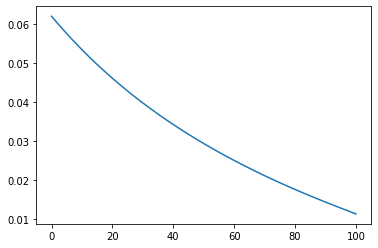

In [33]:
plt.plot(solu['solu_dynamicdmg'][0]['phi'][25])

In [36]:
solu['y_grid'][20]
numy_bar = solu['numy_bar']
numy_bar

20

In [46]:
y = solu['y_grid'][:numy_bar+1]
y.shape

(21,)

In [38]:
# backward induction
rho = .9
mu2 = 1.86/1000
sigma2 = solu['sigma2']

In [39]:
solu_dict = solu['solu_dynamicdmg']
z_grid = solu['z_grid']
y_grid = solu['y_grid']
hz = solu['hz']
hy = solu['hy']
delta = .01
eta = .032
v_n = solu['v_n']

In [42]:
gamma2pList = np.array([0, 2*0.0197])
v0 = solu_dict[gamma2pList[0]]['phi'][:, :numy_bar+1]
v1 = solu_dict[gamma2pList[1]]['phi'][:, :numy_bar+1]

In [47]:
v0.shape, v1.shape

((51, 21), (51, 21))

In [49]:
numdmg = 2
dmg_weights = [.5, .5]
terminal_condition = np.average([v0, v1], axis=0, weights=dmg_weights)

In [51]:
terminal_condition[:]

(51, 21)

In [52]:
numz = solu["numz"]
numy = 50
y_min = 0
y_max = 2
y_grid_new = np.linspace(y_min, y_max, numy)

(z_mat, y_mat) = np.meshgrid(z_grid, y_grid_new, indexing='ij')

In [54]:
gamma2pMat = np.zeros((numdmg, numz, numy))
gamma2pMat[0] = gamma2pList[0]
gamma2pMat[1] = gamma2pList[1]
dlambdaMat = dLambda(y_mat, 1, 0.00017675, 2*0.0022, np.sum(gamma2pList*dmg_weights, axis=0), 2)

In [55]:
np.sum(gamma2pList*dmg_weights, axis=0)

0.0197

In [56]:
hz = z_mat[1,0] - z_mat[0,0]
hy = y_mat[0,1] - y_mat[0,0]
hz, hy

(6.720000000000001e-05, 0.04081632653061224)

In [148]:
def get_coeff(v0, z_mat, y_mat, A, Bz, By, Czz, Cyy, D, epsilon, bounded, bound_cond):
    numz, numy = z_mat.shape
    hz = z_mat[1,0] - z_mat[0,0]
    hy = y_mat[0,1] - y_mat[0,0]
    # coefficient matrix
    LHS = np.zeros((numy*numz, numy*numz))
    RHS = np.zeros(numy*numz)
    RHS += -D -1/epsilon*v0
    for i in range(numz):
        for j in range(numy):
            idx = i*numy + j
            idx_yp1 = idx + 1
            idx_yp2 = idx + 2
            idx_ym1 = idx - 1
            idx_ym2 = idx - 2
            idx_zp1 = (i+1)*numy + j
            idx_zp2 = (i+2)*numy + j
            idx_zm1 = (i-1)*numy + j
            idx_zm2 = (i-2)*numy + j
            LHS[idx, idx] += A[i,j] - 1/epsilon
            # assign coefficient
            # z grid relevant
            if i == 0:
                LHS[idx, idx] += -Bz[i,j]/hz + Czz[i,j]/(hz**2)  
                LHS[idx, idx_zp1] += Bz[i,j]/hz - Czz[i,j]*2/(hz**2)
                LHS[idx, idx_zp2] += Czz[i,j]/(hz**2)
            elif i == numz-1:
                LHS[idx, idx] += Bz[i,j]/hz + Czz[i,j]/(hz**2)
                LHS[idx, idx_zm1] += -Bz[i,j]/hz - 2*Czz[i,j]/(hz**2)
                LHS[idx, idx_zm2] += Czz[i,j]/(hz**2)            
            else:
                LHS[idx, idx_zp1] += Bz[i,j]*(1/hz)*(Bz[i,j] > 0) + Czz[i,j]/(hz**2)
                LHS[idx, idx] += Bz[i,j]*((-1/hz)*(Bz[i,j] > 0) + (1/hz)*(Bz[i,j] <= 0))- 2*Czz[i,j]/(hz**2) 
                LHS[idx, idx_zm1] +=  Bz[i,j]*(-1/hz)*(Bz[i,j] <= 0)+ Czz[i,j]/(hz**2)
            # y grid relevant
            if j == 0:
                LHS[idx, idx_yp2] += Cyy[i,j]/(hy**2)
                LHS[idx, idx_yp1] += By[i,j]/hy - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx] +=  - By[i,j]/hy + Cyy[i,j]/(hy**2)
            elif j == numy-1:
                LHS[idx, idx] += By[i,j]/hy + Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym1] += -By[i,j]/hy - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym2] += Cyy[i,j]/(hy**2)
                if bounded == True:
                    LHS[idx] = 0
                    LHS[idx, idx] =   1
                    RHS[idx] = bound_cond[i]
            else:
                LHS[idx, idx_yp1] += By[i,j]*(1/hy)*(By[i,j] > 0) + Cyy[i,j]/(hy**2)
                LHS[idx, idx] += By[i,j]*((-1/hy)*(By[i,j] > 0) + (1/hy)*(By[i,j] <= 0)) - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym1] += By[i,j]*(-1/hy)*(By[i,j] <= 0) + Cyy[i,j]/(hy**2)  
#    phi_grid = np.linalg.solve(LHS, RHS) 
    return LHS, RHS # phi_grid

In [132]:
def pde_solve(v0, z_mat, y_mat, A, Bz, By, Czz, Cyy, D, epsilon, bounded, bound_cond):
    v0long = v0.reshape(-1)
    D_long = D.reshape(-1)
    LHS, RHS = get_coeff(v0long, z_mat, y_mat, A, Bz, By, Czz, Cyy, D_long, epsilon, bounded, bound_cond)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
    phi_mat = phi_grid.reshape(v0.shape)
    return phi_mat

In [133]:
def false_transient(v0, z_mat, y_mat, 
                    dmg_params, model_params,
                    bound_cond, bounded,
                    epsilon=.5, max_iter=10_000, tol=1e-8):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numz, numy = z_mat.shape
    hz = z_mat[1,0] - z_mat[0,0]
    hy = y_mat[0,1] - y_mat[0,0]
    dlambda = gamma_1 + gamma_2*y_mat\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_mat-gamma_bar)*(y_mat>gamma_bar)
    # initiate v and control
    ems = delta*eta
    error = 1
    episode = 0
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dz = finiteDiff(v0, 0, 1, hz)
        v0_dzz = finiteDiff(v0, 0, 2, hz)
        v0_dy = finiteDiff(v0, 1, 1, hy)
        # control
        ems = (-delta*eta/(v0_dy*z_mat + v_n*dlambda*z_mat))*.5 + ems*.5
        ems[ems<=0] = 1e-16
        A = -delta*np.ones(z_mat.shape)
        Bz = -rho*(z_mat - mu2)
        By = z_mat*ems
        Czz = z_mat*sigma2**2/2
        Cyy = np.zeros(z_mat.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z_mat*ems
        phi_mat = pde_solve(
            v0_old, z_mat, y_mat, A, Bz, By, Czz, Cyy, D,
            epsilon, bounded, bound_cond
        )
        rhs = A*phi_mat + Bz*v0_dz + By*v0_dy + Czz*v0_dzz + D
        rhs_error = np.max(np.abs(rhs))
        error = np.max(np.abs((phi_mat-v0_old)/epsilon))
        v0 = phi_mat
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode,error,rhs_error))
    return v0, ems

In [134]:
gamma_1 = solu['gamma_1']
gamma_2 = solu['gamma_2']
gamma_bar = solu['gamma_bar']

dmgParams = (gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights)
modelParams = (delta, eta, mu2, sigma2, rho, v_n)

In [135]:
modelParams, dmgParams

((0.01, 0.032, 0.00186, 0.013065591353603356, 0.9, -0.968),
 (0.00017675, 0.0044, array([0.    , 0.0394]), 2, [0.5, 0.5]))

## low damage

In [136]:
y_mat

array([[0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ],
       [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ],
       [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ],
       ...,
       [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ],
       [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ],
       [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
        2.        ]])

In [149]:
dmgParams = (gamma_1, gamma_2, gamma2pList, gamma_bar, np.array([1,0]))
modelParams = (delta, eta, mu2, sigma2, rho, v_n)
phi,ems = false_transient(
    np.zeros(z_mat.shape), z_mat, y_mat, dmgParams, modelParams,
    bound_cond=0, bounded=False,
)

Episode: 1	 lhs error: 0.001762700518	 rhs error: 0.002568951113
Episode: 2	 lhs error: 0.001467982939	 rhs error: 0.001809551467
Episode: 3	 lhs error: 0.001319779528	 rhs error: 0.001529837293
Episode: 4	 lhs error: 0.001228090433	 rhs error: 0.001371659718
Episode: 5	 lhs error: 0.001163661296	 rhs error: 0.001265887996
Episode: 6	 lhs error: 0.001114300349	 rhs error: 0.001188698450
Episode: 7	 lhs error: 0.001074359790	 rhs error: 0.001129446792
Episode: 8	 lhs error: 0.001040684834	 rhs error: 0.001082350631
Episode: 9	 lhs error: 0.001011707157	 rhs error: 0.001044082547
Episode: 10	 lhs error: 0.000986532111	 rhs error: 0.001012478243
Episode: 11	 lhs error: 0.000964175945	 rhs error: 0.000985420200
Episode: 12	 lhs error: 0.000944076259	 rhs error: 0.000961942517
Episode: 13	 lhs error: 0.000925756138	 rhs error: 0.000941175130
Episode: 14	 lhs error: 0.000909016784	 rhs error: 0.000922569610
Episode: 15	 lhs error: 0.000893344853	 rhs error: 0.000905469600
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.000325757298	 rhs error: 0.000327493867
Episode: 126	 lhs error: 0.000323376046	 rhs error: 0.000324681854
Episode: 127	 lhs error: 0.000320967858	 rhs error: 0.000322513033
Episode: 128	 lhs error: 0.000318561618	 rhs error: 0.000320230891
Episode: 129	 lhs error: 0.000316202117	 rhs error: 0.000317920151
Episode: 130	 lhs error: 0.000313864951	 rhs error: 0.000315615048
Episode: 131	 lhs error: 0.000311534309	 rhs error: 0.000313323608
Episode: 132	 lhs error: 0.000309273444	 rhs error: 0.000310976826
Episode: 133	 lhs error: 0.000306987768	 rhs error: 0.000308739820
Episode: 134	 lhs error: 0.000304723796	 rhs error: 0.000306521481
Episode: 135	 lhs error: 0.000302513455	 rhs error: 0.000304294799
Episode: 136	 lhs error: 0.000300274054	 rhs error: 0.000302086382
Episode: 137	 lhs error: 0.000298085300	 rhs error: 0.000299894267
Episode: 138	 lhs error: 0.000296315716	 rhs error: 0.000297712809
Episode: 139	 lhs error: 0.000293877533	 rhs error: 0.00029549

Episode: 249	 lhs error: 0.000135334495	 rhs error: 0.000136784758
Episode: 250	 lhs error: 0.000134401352	 rhs error: 0.000135846470
Episode: 251	 lhs error: 0.000133551212	 rhs error: 0.000134917900
Episode: 252	 lhs error: 0.000132611945	 rhs error: 0.000134031723
Episode: 253	 lhs error: 0.000131695113	 rhs error: 0.000133110129
Episode: 254	 lhs error: 0.000130790397	 rhs error: 0.000132188499
Episode: 255	 lhs error: 0.000129957895	 rhs error: 0.000131278723
Episode: 256	 lhs error: 0.000129002286	 rhs error: 0.000130406676
Episode: 257	 lhs error: 0.000128269449	 rhs error: 0.000129544473
Episode: 258	 lhs error: 0.000127444896	 rhs error: 0.000128715851
Episode: 259	 lhs error: 0.000126365964	 rhs error: 0.000127802177
Episode: 260	 lhs error: 0.000125503985	 rhs error: 0.000126894713
Episode: 261	 lhs error: 0.000124645104	 rhs error: 0.000126052749
Episode: 262	 lhs error: 0.000123798194	 rhs error: 0.000125205699
Episode: 263	 lhs error: 0.000123344025	 rhs error: 0.00012436

Episode: 373	 lhs error: 0.000059245729	 rhs error: 0.000060421011
Episode: 374	 lhs error: 0.000058632942	 rhs error: 0.000060025573
Episode: 375	 lhs error: 0.000058241125	 rhs error: 0.000059392526
Episode: 376	 lhs error: 0.000057850371	 rhs error: 0.000059140903
Episode: 377	 lhs error: 0.000057425994	 rhs error: 0.000058773162
Episode: 378	 lhs error: 0.000057102135	 rhs error: 0.000058299634
Episode: 379	 lhs error: 0.000056914756	 rhs error: 0.000058048069
Episode: 380	 lhs error: 0.000056247929	 rhs error: 0.000057661900
Episode: 381	 lhs error: 0.000056017991	 rhs error: 0.000057265147
Episode: 382	 lhs error: 0.000055532019	 rhs error: 0.000056986971
Episode: 383	 lhs error: 0.000055287636	 rhs error: 0.000056416201
Episode: 384	 lhs error: 0.000054913591	 rhs error: 0.000056185636
Episode: 385	 lhs error: 0.000054531539	 rhs error: 0.000055834548
Episode: 386	 lhs error: 0.000054536940	 rhs error: 0.000055466469
Episode: 387	 lhs error: 0.000053901756	 rhs error: 0.00005518

Episode: 497	 lhs error: 0.000026737280	 rhs error: 0.000027940169
Episode: 498	 lhs error: 0.000026501892	 rhs error: 0.000027801973
Episode: 499	 lhs error: 0.000026326856	 rhs error: 0.000027683454
Episode: 500	 lhs error: 0.000026122129	 rhs error: 0.000027559965
Episode: 501	 lhs error: 0.000026115048	 rhs error: 0.000027426709
Episode: 502	 lhs error: 0.000025745743	 rhs error: 0.000027213817
Episode: 503	 lhs error: 0.000025719175	 rhs error: 0.000027047992
Episode: 504	 lhs error: 0.000025606448	 rhs error: 0.000026822368
Episode: 505	 lhs error: 0.000025396920	 rhs error: 0.000026672134
Episode: 506	 lhs error: 0.000025359166	 rhs error: 0.000026491831
Episode: 507	 lhs error: 0.000024901352	 rhs error: 0.000026324507
Episode: 508	 lhs error: 0.000024726808	 rhs error: 0.000026020905
Episode: 509	 lhs error: 0.000024929026	 rhs error: 0.000025837914
Episode: 510	 lhs error: 0.000024517482	 rhs error: 0.000025746330
Episode: 511	 lhs error: 0.000024428568	 rhs error: 0.00002561

Episode: 621	 lhs error: 0.000012343073	 rhs error: 0.000022105835
Episode: 622	 lhs error: 0.000012177221	 rhs error: 0.000022248799
Episode: 623	 lhs error: 0.000012290225	 rhs error: 0.000022350399
Episode: 624	 lhs error: 0.000012168115	 rhs error: 0.000022295257
Episode: 625	 lhs error: 0.000012019822	 rhs error: 0.000022278384
Episode: 626	 lhs error: 0.000011972364	 rhs error: 0.000022294420
Episode: 627	 lhs error: 0.000011947167	 rhs error: 0.000022431569
Episode: 628	 lhs error: 0.000011857003	 rhs error: 0.000022403611
Episode: 629	 lhs error: 0.000011827172	 rhs error: 0.000022570063
Episode: 630	 lhs error: 0.000011733938	 rhs error: 0.000022728225
Episode: 631	 lhs error: 0.000011711034	 rhs error: 0.000022693934
Episode: 632	 lhs error: 0.000011540149	 rhs error: 0.000022653827
Episode: 633	 lhs error: 0.000011567451	 rhs error: 0.000022660999
Episode: 634	 lhs error: 0.000011406737	 rhs error: 0.000022840543
Episode: 635	 lhs error: 0.000011393541	 rhs error: 0.00002282

Episode: 745	 lhs error: 0.000005827713	 rhs error: 0.000027783417
Episode: 746	 lhs error: 0.000006056992	 rhs error: 0.000027755376
Episode: 747	 lhs error: 0.000005804854	 rhs error: 0.000027646168
Episode: 748	 lhs error: 0.000005812826	 rhs error: 0.000027540111
Episode: 749	 lhs error: 0.000005811280	 rhs error: 0.000027566586
Episode: 750	 lhs error: 0.000005735063	 rhs error: 0.000027705061
Episode: 751	 lhs error: 0.000005597422	 rhs error: 0.000027813207
Episode: 752	 lhs error: 0.000005540690	 rhs error: 0.000027877719
Episode: 753	 lhs error: 0.000005755015	 rhs error: 0.000027921783
Episode: 754	 lhs error: 0.000005668392	 rhs error: 0.000027799097
Episode: 755	 lhs error: 0.000005625367	 rhs error: 0.000027773537
Episode: 756	 lhs error: 0.000006993131	 rhs error: 0.000027923661
Episode: 757	 lhs error: 0.000005936425	 rhs error: 0.000028832028
Episode: 758	 lhs error: 0.000005642669	 rhs error: 0.000028405410
Episode: 759	 lhs error: 0.000005306954	 rhs error: 0.00002835

Episode: 869	 lhs error: 0.000002856952	 rhs error: 0.000030931486
Episode: 870	 lhs error: 0.000003295608	 rhs error: 0.000030919320
Episode: 871	 lhs error: 0.000003209015	 rhs error: 0.000030730825
Episode: 872	 lhs error: 0.000002865890	 rhs error: 0.000031029094
Episode: 873	 lhs error: 0.000002906745	 rhs error: 0.000030940185
Episode: 874	 lhs error: 0.000003195951	 rhs error: 0.000030892911
Episode: 875	 lhs error: 0.000003075014	 rhs error: 0.000030713773
Episode: 876	 lhs error: 0.000002856544	 rhs error: 0.000030590803
Episode: 877	 lhs error: 0.000002799655	 rhs error: 0.000030695420
Episode: 878	 lhs error: 0.000002737949	 rhs error: 0.000030769055
Episode: 879	 lhs error: 0.000002715016	 rhs error: 0.000030824926
Episode: 880	 lhs error: 0.000003036986	 rhs error: 0.000030892684
Episode: 881	 lhs error: 0.000002918962	 rhs error: 0.000030724020
Episode: 882	 lhs error: 0.000002797058	 rhs error: 0.000030626561
Episode: 883	 lhs error: 0.000002804556	 rhs error: 0.00003074

Episode: 993	 lhs error: 0.000001393875	 rhs error: 0.000031931278
Episode: 994	 lhs error: 0.000001533116	 rhs error: 0.000031932494
Episode: 995	 lhs error: 0.000001369095	 rhs error: 0.000032020589
Episode: 996	 lhs error: 0.000001468526	 rhs error: 0.000032024826
Episode: 997	 lhs error: 0.000001474439	 rhs error: 0.000032090242
Episode: 998	 lhs error: 0.000002032954	 rhs error: 0.000032177437
Episode: 999	 lhs error: 0.000001844886	 rhs error: 0.000032527416
Episode: 1000	 lhs error: 0.000001695516	 rhs error: 0.000032279604
Episode: 1001	 lhs error: 0.000001339382	 rhs error: 0.000032139310
Episode: 1002	 lhs error: 0.000001645684	 rhs error: 0.000032169176
Episode: 1003	 lhs error: 0.000001420338	 rhs error: 0.000032036156
Episode: 1004	 lhs error: 0.000001500976	 rhs error: 0.000032110163
Episode: 1005	 lhs error: 0.000001688674	 rhs error: 0.000032032087
Episode: 1006	 lhs error: 0.000001585032	 rhs error: 0.000032258721
Episode: 1007	 lhs error: 0.000001596141	 rhs error: 0.

Episode: 1115	 lhs error: 0.000001062735	 rhs error: 0.000032740146
Episode: 1116	 lhs error: 0.000000824833	 rhs error: 0.000032614939
Episode: 1117	 lhs error: 0.000000953639	 rhs error: 0.000032697485
Episode: 1118	 lhs error: 0.000000853301	 rhs error: 0.000032589944
Episode: 1119	 lhs error: 0.000000954029	 rhs error: 0.000032687068
Episode: 1120	 lhs error: 0.000001013386	 rhs error: 0.000032800348
Episode: 1121	 lhs error: 0.000000958978	 rhs error: 0.000032660548
Episode: 1122	 lhs error: 0.000000861197	 rhs error: 0.000032554697
Episode: 1123	 lhs error: 0.000000785250	 rhs error: 0.000032489959
Episode: 1124	 lhs error: 0.000000729175	 rhs error: 0.000032454290
Episode: 1125	 lhs error: 0.000000731531	 rhs error: 0.000032438867
Episode: 1126	 lhs error: 0.000000948942	 rhs error: 0.000032421420
Episode: 1127	 lhs error: 0.000000809957	 rhs error: 0.000032568431
Episode: 1128	 lhs error: 0.000000804946	 rhs error: 0.000032495694
Episode: 1129	 lhs error: 0.000000731325	 rhs er

Episode: 1237	 lhs error: 0.000000484902	 rhs error: 0.000032781752
Episode: 1238	 lhs error: 0.000000638187	 rhs error: 0.000032743564
Episode: 1239	 lhs error: 0.000000544134	 rhs error: 0.000032884303
Episode: 1240	 lhs error: 0.000000497437	 rhs error: 0.000032782712
Episode: 1241	 lhs error: 0.000000647631	 rhs error: 0.000032745629
Episode: 1242	 lhs error: 0.000000572639	 rhs error: 0.000032894054
Episode: 1243	 lhs error: 0.000000735946	 rhs error: 0.000032996735
Episode: 1244	 lhs error: 0.000000682847	 rhs error: 0.000033177866
Episode: 1245	 lhs error: 0.000000624487	 rhs error: 0.000033016199
Episode: 1246	 lhs error: 0.000000534437	 rhs error: 0.000032905777
Episode: 1247	 lhs error: 0.000000584939	 rhs error: 0.000032837295
Episode: 1248	 lhs error: 0.000000448105	 rhs error: 0.000032959632
Episode: 1249	 lhs error: 0.000000538699	 rhs error: 0.000032910632
Episode: 1250	 lhs error: 0.000001335403	 rhs error: 0.000033015140
Episode: 1251	 lhs error: 0.000000796484	 rhs er

Episode: 1359	 lhs error: 0.000000388460	 rhs error: 0.000032997751
Episode: 1360	 lhs error: 0.000000337106	 rhs error: 0.000032927430
Episode: 1361	 lhs error: 0.000000298860	 rhs error: 0.000032878337
Episode: 1362	 lhs error: 0.000000271950	 rhs error: 0.000032844689
Episode: 1363	 lhs error: 0.000000252132	 rhs error: 0.000032821724
Episode: 1364	 lhs error: 0.000000238112	 rhs error: 0.000032806470
Episode: 1365	 lhs error: 0.000000227433	 rhs error: 0.000032796431
Episode: 1366	 lhs error: 0.000000219457	 rhs error: 0.000032790175
Episode: 1367	 lhs error: 0.000000212959	 rhs error: 0.000032786519
Episode: 1368	 lhs error: 0.000000207543	 rhs error: 0.000032784817
Episode: 1369	 lhs error: 0.000000202647	 rhs error: 0.000032784584
Episode: 1370	 lhs error: 0.000000198710	 rhs error: 0.000032785578
Episode: 1371	 lhs error: 0.000000197166	 rhs error: 0.000032787434
Episode: 1372	 lhs error: 0.000000195542	 rhs error: 0.000032789379
Episode: 1373	 lhs error: 0.000000194781	 rhs er

Episode: 1481	 lhs error: 0.000000348061	 rhs error: 0.000033107794
Episode: 1482	 lhs error: 0.000000103391	 rhs error: 0.000033218608
Episode: 1483	 lhs error: 0.000000312944	 rhs error: 0.000033220915
Episode: 1484	 lhs error: 0.000000319212	 rhs error: 0.000033132119
Episode: 1485	 lhs error: 0.000000266979	 rhs error: 0.000033236646
Episode: 1486	 lhs error: 0.000000379082	 rhs error: 0.000033304940
Episode: 1487	 lhs error: 0.000000667078	 rhs error: 0.000033188960
Episode: 1488	 lhs error: 0.000000416096	 rhs error: 0.000033449174
Episode: 1489	 lhs error: 0.000000419556	 rhs error: 0.000033288563
Episode: 1490	 lhs error: 0.000000292762	 rhs error: 0.000033162413
Episode: 1491	 lhs error: 0.000000641071	 rhs error: 0.000033260090
Episode: 1492	 lhs error: 0.000000483359	 rhs error: 0.000033494956
Episode: 1493	 lhs error: 0.000000193142	 rhs error: 0.000033310340
Episode: 1494	 lhs error: 0.000000391991	 rhs error: 0.000033363073
Episode: 1495	 lhs error: 0.000000538066	 rhs er

Episode: 1603	 lhs error: 0.000000168827	 rhs error: 0.000033141137
Episode: 1604	 lhs error: 0.000000112029	 rhs error: 0.000033144387
Episode: 1605	 lhs error: 0.000000214613	 rhs error: 0.000033127234
Episode: 1606	 lhs error: 0.000000140235	 rhs error: 0.000033065224
Episode: 1607	 lhs error: 0.000000166695	 rhs error: 0.000033036861
Episode: 1608	 lhs error: 0.000000394122	 rhs error: 0.000032999245
Episode: 1609	 lhs error: 0.000000168925	 rhs error: 0.000033153799
Episode: 1610	 lhs error: 0.000000334625	 rhs error: 0.000033102098
Episode: 1611	 lhs error: 0.000000160326	 rhs error: 0.000033229086
Episode: 1612	 lhs error: 0.000000283618	 rhs error: 0.000033180618
Episode: 1613	 lhs error: 0.000000124250	 rhs error: 0.000033283928
Episode: 1614	 lhs error: 0.000000239422	 rhs error: 0.000033249726
Episode: 1615	 lhs error: 0.000000096395	 rhs error: 0.000033331382
Episode: 1616	 lhs error: 0.000000323107	 rhs error: 0.000033306488
Episode: 1617	 lhs error: 0.000000273560	 rhs er

Episode: 1725	 lhs error: 0.000000639209	 rhs error: 0.000033416335
Episode: 1726	 lhs error: 0.000000498258	 rhs error: 0.000033410903
Episode: 1727	 lhs error: 0.000000360850	 rhs error: 0.000033269782
Episode: 1728	 lhs error: 0.000000329035	 rhs error: 0.000033173107
Episode: 1729	 lhs error: 0.000000234964	 rhs error: 0.000033084183
Episode: 1730	 lhs error: 0.000000204692	 rhs error: 0.000033035385
Episode: 1731	 lhs error: 0.000000244653	 rhs error: 0.000033102460
Episode: 1732	 lhs error: 0.000000352680	 rhs error: 0.000033036026
Episode: 1733	 lhs error: 0.000000261140	 rhs error: 0.000033172787
Episode: 1734	 lhs error: 0.000000312815	 rhs error: 0.000033097391
Episode: 1735	 lhs error: 0.000000181281	 rhs error: 0.000033218289
Episode: 1736	 lhs error: 0.000000175290	 rhs error: 0.000033173539
Episode: 1737	 lhs error: 0.000000241972	 rhs error: 0.000033139580
Episode: 1738	 lhs error: 0.000000329425	 rhs error: 0.000033237782
Episode: 1739	 lhs error: 0.000000283559	 rhs er

Episode: 1847	 lhs error: 0.000000196663	 rhs error: 0.000033175730
Episode: 1848	 lhs error: 0.000000120564	 rhs error: 0.000033108074
Episode: 1849	 lhs error: 0.000000107926	 rhs error: 0.000033075084
Episode: 1850	 lhs error: 0.000000067205	 rhs error: 0.000033045674
Episode: 1851	 lhs error: 0.000000099424	 rhs error: 0.000033031820
Episode: 1852	 lhs error: 0.000000383649	 rhs error: 0.000033006978
Episode: 1853	 lhs error: 0.000000131188	 rhs error: 0.000033173055
Episode: 1854	 lhs error: 0.000000308973	 rhs error: 0.000033121812
Episode: 1855	 lhs error: 0.000000141888	 rhs error: 0.000033254551
Episode: 1856	 lhs error: 0.000000258252	 rhs error: 0.000033198581
Episode: 1857	 lhs error: 0.000000081370	 rhs error: 0.000033308131
Episode: 1858	 lhs error: 0.000001016612	 rhs error: 0.000033279692
Episode: 1859	 lhs error: 0.000000484580	 rhs error: 0.000033704564
Episode: 1860	 lhs error: 0.000000407212	 rhs error: 0.000033460476
Episode: 1861	 lhs error: 0.000000153613	 rhs er

Episode: 1969	 lhs error: 0.000000304558	 rhs error: 0.000033245958
Episode: 1970	 lhs error: 0.000000231965	 rhs error: 0.000033141988
Episode: 1971	 lhs error: 0.000000187769	 rhs error: 0.000033076302
Episode: 1972	 lhs error: 0.000000343877	 rhs error: 0.000033030660
Episode: 1973	 lhs error: 0.000000544627	 rhs error: 0.000033181127
Episode: 1974	 lhs error: 0.000000131003	 rhs error: 0.000033412818
Episode: 1975	 lhs error: 0.000000077880	 rhs error: 0.000033443748
Episode: 1976	 lhs error: 0.000001790716	 rhs error: 0.000033475305
Episode: 1977	 lhs error: 0.000000673272	 rhs error: 0.000034224105
Episode: 1978	 lhs error: 0.000000767466	 rhs error: 0.000033880554
Episode: 1979	 lhs error: 0.000000555039	 rhs error: 0.000033573875
Episode: 1980	 lhs error: 0.000000355019	 rhs error: 0.000033374832
Episode: 1981	 lhs error: 0.000000301437	 rhs error: 0.000033253980
Episode: 1982	 lhs error: 0.000000254658	 rhs error: 0.000033156937
Episode: 1983	 lhs error: 0.000000174305	 rhs er

Episode: 2091	 lhs error: 0.000000243135	 rhs error: 0.000033206308
Episode: 2092	 lhs error: 0.000000182510	 rhs error: 0.000033313591
Episode: 2093	 lhs error: 0.000000129319	 rhs error: 0.000033385667
Episode: 2094	 lhs error: 0.000001325026	 rhs error: 0.000033440466
Episode: 2095	 lhs error: 0.000000585200	 rhs error: 0.000033989507
Episode: 2096	 lhs error: 0.000000118598	 rhs error: 0.000033687758
Episode: 2097	 lhs error: 0.000000555999	 rhs error: 0.000033651387
Episode: 2098	 lhs error: 0.000000604519	 rhs error: 0.000033881783
Episode: 2099	 lhs error: 0.000000246016	 rhs error: 0.000033598964
Episode: 2100	 lhs error: 0.000000437797	 rhs error: 0.000033504143
Episode: 2101	 lhs error: 0.000000135466	 rhs error: 0.000033329576
Episode: 2102	 lhs error: 0.000000295761	 rhs error: 0.000033393684
Episode: 2103	 lhs error: 0.000000249936	 rhs error: 0.000033273151
Episode: 2104	 lhs error: 0.000000189623	 rhs error: 0.000033130611
Episode: 2105	 lhs error: 0.000000152059	 rhs er

Episode: 2213	 lhs error: 0.000000189130	 rhs error: 0.000033172130
Episode: 2214	 lhs error: 0.000000119549	 rhs error: 0.000033094738
Episode: 2215	 lhs error: 0.000000116165	 rhs error: 0.000033148187
Episode: 2216	 lhs error: 0.000000154401	 rhs error: 0.000033107007
Episode: 2217	 lhs error: 0.000000083759	 rhs error: 0.000033057841
Episode: 2218	 lhs error: 0.000000140093	 rhs error: 0.000033094085
Episode: 2219	 lhs error: 0.000000347464	 rhs error: 0.000033046793
Episode: 2220	 lhs error: 0.000000159265	 rhs error: 0.000033201247
Episode: 2221	 lhs error: 0.000000290008	 rhs error: 0.000033138720
Episode: 2222	 lhs error: 0.000000130440	 rhs error: 0.000033266690
Episode: 2223	 lhs error: 0.000000242815	 rhs error: 0.000033215460
Episode: 2224	 lhs error: 0.000000030227	 rhs error: 0.000033320239
Episode: 2225	 lhs error: 0.000000256929	 rhs error: 0.000033309901
Episode: 2226	 lhs error: 0.000000174232	 rhs error: 0.000033419457
Episode: 2227	 lhs error: 0.000000065712	 rhs er

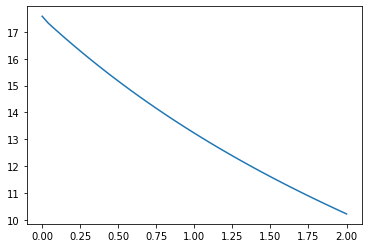

In [150]:
plt.plot(y_grid_new, ems[25])